<a href="https://colab.research.google.com/github/Arthur-ca/MIE1517/blob/Jing-Guo/ExtractFeatures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import numpy as np
import os
from sklearn.model_selection import train_test_split
import random
import torchvision
from torchvision import datasets, models
from collections import defaultdict
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as F1
import matplotlib.pyplot as plt
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from PIL import Image
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from torchvision.datasets import ImageFolder
import tensorflow as tf
import gc
from collections import Counter
import imgaug.augmenters as iaa
import cv2
import dlib
from collections import defaultdict
from matplotlib import pyplot as plt

In [ ]:
#First link it to google drive and check the subfolder of the data
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
classeses = []
for i in os.listdir('/content/gdrive/MyDrive/MIE1517/Hands/archive'):
    if i!=5:
        classeses.append(i)
classeses

['contempt',
 'neutrality',
 'sadness',
 'disgust',
 'fear',
 'anger',
 'happiness',
 'surprise']

In [ ]:
!wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
!bzip2 -d shape_predictor_68_face_landmarks.dat.bz2

--2023-11-28 22:09:02--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2.1’

shape_predictor_68_ 100%[===================>]  61.07M  15.7MB/s    in 6.1s    

2023-11-28 22:09:08 (10.0 MB/s) - ‘shape_predictor_68_face_landmarks.dat.bz2.1’ saved [64040097/64040097]

bzip2: Output file shape_predictor_68_face_landmarks.dat already exists.


In [15]:
import cv2
import dlib
import numpy as np
import os
from collections import Counter

# Initialize Dlib's face detector (HOG-based) and facial landmark predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('/content/shape_predictor_68_face_landmarks.dat')

# Function to extract and combine eyes, eyebrows, and mouth into a single image
def extract_and_combine_regions(gray, landmarks):
    # Create masks for eyes including eyebrows and mouth
    mask_eyes_eyebrows = np.zeros_like(gray)
    mask_mouth = np.zeros_like(gray)

    # Points for eyes and eyebrows
    eyes_eyebrows_points = np.concatenate([
        np.array([(landmarks.part(n).x, landmarks.part(n).y) for n in range(17, 27)]),  # Eyebrows
        np.array([(landmarks.part(n).x, landmarks.part(n).y) for n in range(36, 48)])   # Eyes
    ])

    # Points for mouth
    mouth_points = np.array([(landmarks.part(n).x, landmarks.part(n).y) for n in range(48, 68)])  # Mouth

    # Fill the masks with the polygons defined by points
    cv2.fillPoly(mask_eyes_eyebrows, [eyes_eyebrows_points], 255)
    cv2.fillPoly(mask_mouth, [mouth_points], 255)

    # Use the masks to extract the regions from the image
    eyes_eyebrows_region = cv2.bitwise_and(gray, mask_eyes_eyebrows)
    mouth_region = cv2.bitwise_and(gray, mask_mouth)

    # Combine the regions on a black background
    combined_image = np.zeros_like(gray)
    combined_image[mask_eyes_eyebrows == 255] = eyes_eyebrows_region[mask_eyes_eyebrows == 255]
    combined_image[mask_mouth == 255] = mouth_region[mask_mouth == 255]

    return combined_image

# Your existing code to load images
features_or = []
labels_or = []
train_data_or = []
failed_indices = []
def create_images():
    for i, photo in enumerate(classeses):
        path = os.path.join('/content/gdrive/MyDrive/MIE1517/Hands/archive', photo)
        label = i  # Use the index of the class as the label

        for img_name in os.listdir(path):
            img_path = os.path.join(path, img_name)
            img = cv2.imread(img_path)

            if img is None:
                continue

            # Convert the image to grayscale
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            # Apply CLAHE to improve the contrast locally
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
            gray_clahe = clahe.apply(gray)

            # Detect faces in the CLAHE preprocessed image
            faces = detector(gray_clahe, 1)

            # If no faces are detected with CLAHE, try standard histogram equalization
            if len(faces) == 0:
                gray_eq = cv2.equalizeHist(gray)
                faces = detector(gray_eq, 1)
                image_to_use = gray_eq
            else:
                image_to_use = gray_clahe

            if len(faces) > 0:
                face = faces[0]
                landmarks = predictor(image_to_use, face)
                combined_region = extract_and_combine_regions(image_to_use, landmarks)

                # Append the combined image and its label to the list
                features_or.append(combined_region)  # Append the combined region
                labels_or.append(label)

                train_data_or.append([combined_region, label])
            else:
                failed_indices.append(i)

create_images()
# Print the label counts
label_counts_or = Counter(labels_or)
for label, count in label_counts_or.items():
    print(f"Label {label}: {count} images")

Label 0: 142 images
Label 1: 419 images
Label 2: 448 images
Label 3: 292 images
Label 4: 372 images
Label 5: 585 images
Label 6: 896 images
Label 7: 600 images


In [23]:
# Initialize Dlib's face detector (HOG-based) and facial landmark predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('/content/shape_predictor_68_face_landmarks.dat')

# Function to extract and combine eyes, eyebrows, and mouth into a single image
def extract_and_combine_regions(gray, landmarks):
    # Create masks for eyes including eyebrows and mouth
    mask_eyes_eyebrows = np.zeros_like(gray)
    mask_mouth = np.zeros_like(gray)

    # Points for eyes and eyebrows
    eyes_eyebrows_points = np.concatenate([
        np.array([(landmarks.part(n).x, landmarks.part(n).y) for n in range(17, 27)]),  # Eyebrows
        np.array([(landmarks.part(n).x, landmarks.part(n).y) for n in range(36, 48)])   # Eyes
    ])

    # Points for mouth
    mouth_points = np.array([(landmarks.part(n).x, landmarks.part(n).y) for n in range(48, 68)])  # Mouth

    # Fill the masks with the polygons defined by points
    cv2.fillPoly(mask_eyes_eyebrows, [eyes_eyebrows_points], 255)
    cv2.fillPoly(mask_mouth, [mouth_points], 255)

    # Use the masks to extract the regions from the image
    eyes_eyebrows_region = cv2.bitwise_and(gray, mask_eyes_eyebrows)
    mouth_region = cv2.bitwise_and(gray, mask_mouth)

    # Combine the regions on a black background
    combined_image = np.zeros_like(gray)
    combined_image[mask_eyes_eyebrows == 255] = eyes_eyebrows_region[mask_eyes_eyebrows == 255]
    combined_image[mask_mouth == 255] = mouth_region[mask_mouth == 255]

    return combined_image
def create_images_and_save(directory, save_originals_dir, save_combined_dir):
    features_or = []
    labels_or = []
    train_data_or = []
    failed_indices = []

    # Create subdirectories for each label in both save directories
    for label in classeses:
        os.makedirs(os.path.join(save_originals_dir, label), exist_ok=True)
        os.makedirs(os.path.join(save_combined_dir, label), exist_ok=True)

    for i, photo in enumerate(classeses):
        path = os.path.join(directory, photo)
        label = photo  # Use the name of the folder as the label

        for img_name in os.listdir(path):
            img_path = os.path.join(path, img_name)
            img = cv2.imread(img_path)

            if img is None:
                continue

            # Convert the image to grayscale and apply CLAHE
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            # Apply CLAHE to improve the contrast locally
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
            gray_clahe = clahe.apply(gray)

            # Detect faces in the CLAHE preprocessed image
            faces = detector(gray_clahe, 1)
            # If no faces are detected with CLAHE, try standard histogram equalization
            if len(faces) == 0:
                gray_eq = cv2.equalizeHist(gray)
                faces = detector(gray_eq, 1)
                image_to_use = gray_eq
            else:
                image_to_use = gray_clahe

            if len(faces) > 0:
                face = faces[0]
                landmarks = predictor(image_to_use, face)
                combined_region = extract_and_combine_regions(image_to_use, landmarks)

                # Define paths for saving images
                original_img_path = os.path.join(save_originals_dir, label, img_name)
                combined_img_path = os.path.join(save_combined_dir, label, img_name)

                # Save the original and combined images
                cv2.imwrite(original_img_path, img)  # Save original image
                cv2.imwrite(combined_img_path, combined_region)  # Save combined image

                # Append the combined image and its label to the list
                features_or.append(combined_region)
                labels_or.append(i)  # We use the index for the label here

                train_data_or.append([combined_region, i])  # Append the combined region and label index
            else:
                failed_indices.append(i)

    return features_or, labels_or, train_data_or, failed_indices

# Call the function with updated paths
dataset_directory = '/content/gdrive/MyDrive/MIE1517/Hands/archive'
save_originals_directory = '/content/saved_original'
save_combined_directory = '/content/saved_combine'

features_or, labels_or, train_data_or, failed_indices = create_images_and_save(
    dataset_directory,
    save_originals_directory,
    save_combined_directory
)

# Print the label counts and failed indices
label_counts_or = Counter(labels_or)
for label, count in label_counts_or.items():
    print(f"Label {label}: {count} images")

Label 0: 142 images
Label 1: 419 images
Label 2: 448 images
Label 3: 292 images
Label 4: 372 images
Label 5: 585 images
Label 6: 896 images
Label 7: 600 images


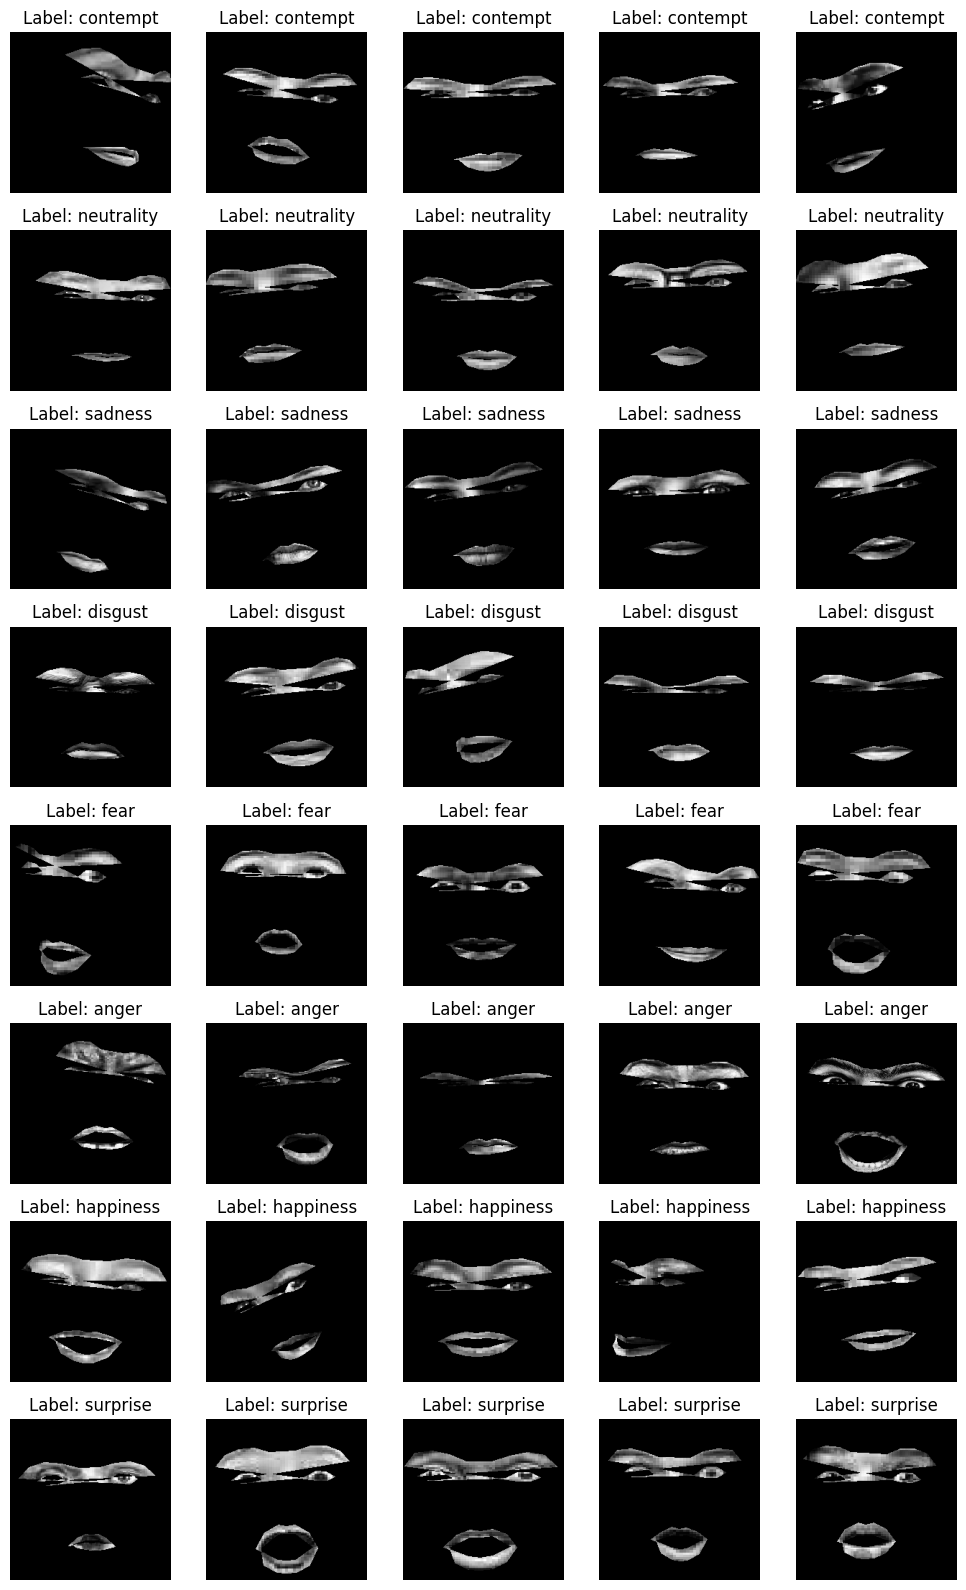

In [16]:
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np
import cv2

def plot_first_n_images(images, labels, classes, n=5):
    num_labels = len(classes)  # Get the number of unique labels
    fig, axes = plt.subplots(num_labels, n, figsize=(n*2, num_labels*2))

    # Initialize a dictionary to store image indices for each label
    label_indices = defaultdict(list)

    # Populate the dictionary with indices of images for each label
    for index, label in enumerate(labels):
        label_indices[label].append(index)

    # Plot 'n' images for each label
    for label_idx, label in enumerate(classes):
        indices = label_indices[label_idx][:n]  # Get the first 'n' indices for this label
        for img_idx, img_index in enumerate(indices):
            axes[label_idx, img_idx].imshow(images[img_index], cmap='gray')
            axes[label_idx, img_idx].set_title(f"Label: {label}")
            axes[label_idx, img_idx].axis('off')

    plt.tight_layout()
    plt.show()

# plot each emotion
plot_first_n_images(features_or, labels_or, classeses, n=5)

In [24]:
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data import random_split
# Preprocess and transform the images
transform = transforms.Compose([
    transforms.ToTensor(),
    # Add any additional transforms you might need
])

# Convert the processed images and labels into tensors and apply transforms
def prepare_dataset(images, labels, transform):
    tensor_images = [transform(image) for image in images]
    tensor_labels = torch.tensor(labels, dtype=torch.long)
    return TensorDataset(torch.stack(tensor_images), tensor_labels)

# Prepare datasets for eyes, eyebrows, and mouth
combined_dataset = prepare_dataset(features_or, labels_or, transform)

# split your datasets into training, validation, and test sets with a 60-20-20 percent ratio,
def split_dataset(dataset, train_percent=0.60, val_percent=0.20):
    total_size = len(dataset)
    train_size = int(total_size * train_percent)
    val_size = int(total_size * val_percent)
    test_size = total_size - train_size - val_size

    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
    return train_dataset, val_dataset, test_dataset


# Split each dataset into training, validation, and test sets
combined_train_dataset, combined_val_dataset, combined_test_dataset = split_dataset(combined_dataset)


# Create DataLoaders for training and validation for each region
Combined_train_loader = DataLoader(combined_train_dataset, batch_size=64, shuffle=True)
Combined_val_loader = DataLoader(combined_val_dataset, batch_size=64, shuffle=False)


Model

In [25]:
import torch.nn as nn
import torch.nn.functional as F

class CombinedCNN(nn.Module):
    def __init__(self, num_classes):
        super(CombinedCNN, self).__init__()

        # Define convolutional layers using nn.Sequential
        self.conv_layers = nn.Sequential(
            # Convolutional Layer 1
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  # Assuming input channels = 1 (grayscale)
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            # Convolutional Layer 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            # Convolutional Layer 3
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            # Convolutional Layer 4
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            # Convolutional Layer 5
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )

        # Define fully connected layers using nn.Sequential
        self.fc_layers = nn.Sequential(
            nn.Linear(512 * 7 * 7, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, num_classes)
        )

    def forward(self, x):
        # Apply convolutional layers
        x = self.conv_layers(x)

        # Flatten the output for the fully connected layers
        x = x.view(-1, 512 * 7 * 7)

        # Apply fully connected layers
        x = self.fc_layers(x)

        return x

num_classes = 8
combined_model = CombinedCNN(num_classes)

Train Region-Specific CNNs (RegionCNN):
Train the RegionCNN models separately for each facial region (eyes, eyebrows, mouth) using the corresponding part of the face images.


In [26]:
def get_model_name(name, batch_size, learning_rate, epoch):
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name, batch_size, learning_rate, epoch)
    return path

def evaluate(model, loader):
    """ Evaluate the network """
    correct = 0
    total = 0

    for inputs, labels in loader:
      if use_cuda and torch.cuda.is_available():
        inputs = inputs.cuda()
        labels = labels.cuda()

      outputs = model(inputs)
      predicted = outputs.max(1, keepdim=True)[1]
      total += inputs.shape[0]
      correct += predicted.eq(labels.view_as(predicted)).sum().item()
    return correct / total

In [29]:
import time
def trainmodel(model, train_dataset, val_dataset, batch=64, learningRate=0.001, num_epochs=300):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learningRate)

    model_checkpoint_path = 'D:/MIE1517/output'

    train_loader = DataLoader(train_dataset, batch_size=batch, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch, shuffle=False)

    train_accuracy = np.zeros(num_epochs)
    train_losses = np.zeros(num_epochs)
    validation_accuracy = np.zeros(num_epochs)
    validation_losses = np.zeros(num_epochs)

    use_cuda = torch.cuda.is_available()
    if use_cuda:
        model = model.cuda()

    print("Training Begin...\n")
    start_time = time.time()
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            if use_cuda:
                inputs = inputs.cuda()
                labels = labels.cuda()
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_losses[epoch] = running_loss / len(train_loader)
        train_accuracy[epoch] = evaluate(model, train_loader)

        model.eval()
        valid_loss = 0.0
        for inputs, labels in val_loader:
            if use_cuda:
                inputs = inputs.cuda()
                labels = labels.cuda()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()

        validation_losses[epoch] = valid_loss / len(val_loader)
        validation_accuracy[epoch] = evaluate(model, val_loader)

        print(f"Epoch {epoch+1}: Train Acc: {train_accuracy[epoch]:.2f}, Train Loss: {train_losses[epoch]:.4f} | "
              f"Val Acc: {validation_accuracy[epoch]:.2f}, Val Loss: {validation_losses[epoch]:.4f}")

        model_path = get_model_name(model.name, batch, learningRate, epoch)
        model_path = os.path.join(model_checkpoint_path, model_path)
        torch.save(model.state_dict(), f"{model_path}.pt")

    print("Finished Training")
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Total time elapsed: {elapsed_time:.2f} seconds")

    # Plotting
    epochs = np.arange(1, num_epochs + 1)
    plt.figure(figsize=(14, 7))

    plt.subplot(2, 1, 1)
    plt.title("Training and Validation Loss")
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, validation_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.title("Training and Validation Accuracy")
    plt.plot(epochs, train_accuracy, label="Train Accuracy")
    plt.plot(epochs, validation_accuracy, label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

    return train_losses, train_accuracy, validation_losses, validation_accuracy

In [ ]:
Model1 = trainmodel(combined_model, combined_train_dataset, combined_val_dataset, batch=64, learningRate=0.01, num_epochs=300)


Training Begin...

